In [1]:
import pycellin as pc

### Adding pre-defined features

In [2]:
xml_path = "../sample_data/Ecoli_growth_on_agar_pad.xml"
model = pc.load_TrackMate_XML(xml_path)
print(model)

Model with 3 lineages.


In [3]:
pc.get_pycellin_cell_lineage_features()
model.add_pycellin_features(["relative_age", "cell_length"])
model.add_cell_width(
    method_width="median", width_ignore_tips=True, rename="cell_width_no_tips"
)
model.add_cycle_data()



model.add_pycellin_features(["division_time", "cell_cycle_completeness"])
model.update()

In [4]:
lin0 = model.data.cell_data[0]
lin0.plot(
    node_hover_features=["cell_ID", "relative_age", "cell_length", "cell_width_no_tips"]
)

In [5]:
cyclelin0 = model.data.cycle_data[0]
cyclelin0.plot(
    title="Cycle lineage of lineage ID 0",
    node_hover_features=[
        "cycle_ID",
        "level",
        "division_time",
        "cell_cycle_completeness",
    ],
)

### Adding custom feature

In [6]:
feat = pc.Feature(
    name="node_ID_parity",
    description="Parity of the node ID",
    lineage_type="CellLineage",
    provenance="Pycellin",
    data_type="int",
)


class ParityCalculator(pc.NodeLocalFeatureCalculator):

    def compute(self, lineage, noi):
        # `lineage` is unused here, but it is still a required argument.
        if noi % 2 == 0:
            return True
        else:
            return False

In [7]:
model.add_custom_feature(feat, ParityCalculator)
model.update()

### Changing the lineages structures and updating the features

In [8]:
new_cell_ID = model.add_cell(lineage_ID=0, frame=21)
model.link_cells(source_cell_ID=9326, source_lineage_ID=0, target_cell_ID=new_cell_ID)

In [9]:
model.is_update_required()

True

In [10]:
# We remove morphology related features since we don't have the data for them for the new cell.
model.remove_feature("cell_length", "node")
model.remove_feature("cell_width_no_tips", "node")
model.update()

In [11]:
lin0 = model.data.cell_data[0]
lin0.plot(node_hover_features=["cell_ID", "relative_age", "node_ID_parity"])

### Node age

In [1]:
import pycellin as pc

In [2]:
# Path to the TrackMate XML file.
xml_path1 = "../sample_data/Ecoli_growth_on_agar_pad.xml"
xml_path2 = "../sample_data/Ecoli_growth_on_agar_pad_with_gaps.xml"


# Parse the XML file and create a Pycellin Model object
# that contains all the data from the XML file.
model1 = pc.load_TrackMate_XML(xml_path1)
model2 = pc.load_TrackMate_XML(xml_path2)

# We can display basic information about this model.
print(model1)
print(f"This model contains {model1.data.number_of_lineages()} lineages:")
for lin_ID, lineage in model1.data.cell_data.items():
    print(f"- ID {lin_ID}: {lineage}")

Model with 3 lineages.
This model contains 3 lineages:
- ID 0: CellLineage named 'Track_0' with 152 nodes and 151 edges
- ID 1: CellLineage named 'Track_1' with 189 nodes and 188 edges
- ID 2: CellLineage named 'Track_2' with 185 nodes and 184 edges


In [3]:
model1.add_pycellin_features(["absolute_age", "relative_age"])
model1.update()

In [4]:
lin0_1 = model1.data.cell_data[0]

In [5]:
lin0_1.plot(node_hover_features=["cell_ID", "absolute_age", "relative_age"])

In [6]:
model2.add_pycellin_features(["absolute_age", "relative_age"])
model2.update()
lin0_2 = model2.data.cell_data[0]
lin0_2.plot(node_hover_features=["cell_ID", "absolute_age", "relative_age"])

### No segmentation

In [11]:
import pycellin as pc

In [12]:
xml = "E:/Pasteur/LS_data/LStoLX/230328GreffeGakaYFPMyogTdtmdxFDBTryplen1-movie01-01-Scene-15-TR37-A01.xml"
model = pc.load_TrackMate_XML(xml)
print(model)

Model with 1 lineage.


In [13]:
model.add_pycellin_features(["relative_age", "absolute_age"])
model.add_cycle_data()
model.add_pycellin_features(["division_time", "cell_cycle_completeness"])
model.update()

In [14]:
model.get_cycle_lineage_features()

['cycle_ID',
 'cells',
 'cycle_length',
 'level',
 'division_time',
 'cell_cycle_completeness',
 'cycle_lineage_ID']

In [15]:
lin0 = model.data.cell_data[0]
lin0.plot(node_hover_features=["cell_ID", "relative_age", "absolute_age"])

In [16]:
cyclelin0 = model.data.cycle_data[0]
cyclelin0.plot(
    title="Cycle lineage of lineage ID 0",
    node_hover_features=[
        "cycle_ID",
        "level",
        "division_time",
        "cell_cycle_completeness",
    ],
)

### EpiCure

In [1]:
import pickle

# import napari
import networkx as nx
import matplotlib.pyplot as plt

import pycellin as pc

In [2]:
epi_file = "/mnt/data/Code/EpiCure_small_example/epics/013_crop_epidata.pkl"

In [3]:
with open(epi_file, "rb") as f:
    epidata = pickle.load(f)

for k, v in epidata.items():
    print(k, v)

EpiMetaData {'ScaleXY': 1, 'UnitXY': 'um', 'ScaleT': 1, 'UnitT': 'min', 'MainChannel': 0, 'Allow gaps': True, 'Verbose': 2}
Group {'paf': [48, 60, 70]}
Graph {167: [24], 172: [24], 393: [112], 397: [112], 492: [76], 505: [76], 645: [505], 658: [505], 1013: [33], 1016: [33], 1059: [916], 1066: [916], 1204: [82], 1200: [82], 1237: [674], 1240: [674], 1309: [46], 1321: [46], 1522: [1380], 1526: [1380], 208: [65, 72], 306: [167, 172], 674: [393, 397], 916: [492, 645], 1293: [32, 1016], 1345: [1200, 1204], 1380: [1237, 1240], 1465: [1321, 58]}
Events {'Points': array([[  1,  22,  30],
       [  2, 139,  68],
       [  3,  99,  19],
       [  4, 111,  15],
       [  7,  31, 212],
       [  7,  99,  19],
       [  8,  93,  43],
       [  8, 138,  68],
       [  9,  53, 197],
       [ 10, 138,  69]]), 'Props': {'id': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16), 'label': array([  24,  112,   76,  505,   33,  916,   82,  674,   46, 1380],
      dtype=uint16), 'score': array([1, 1, 1, 1, 

In [4]:
graph_data = epidata["Graph"]
print(graph_data)

{167: [24], 172: [24], 393: [112], 397: [112], 492: [76], 505: [76], 645: [505], 658: [505], 1013: [33], 1016: [33], 1059: [916], 1066: [916], 1204: [82], 1200: [82], 1237: [674], 1240: [674], 1309: [46], 1321: [46], 1522: [1380], 1526: [1380], 208: [65, 72], 306: [167, 172], 674: [393, 397], 916: [492, 645], 1293: [32, 1016], 1345: [1200, 1204], 1380: [1237, 1240], 1465: [1321, 58]}


Using nx.from_dict_of_lists:

In [5]:
inverted_dict = {}
for key, value_list in graph_data.items():
    for value in value_list:
        if value in inverted_dict:
            inverted_dict[value].append(key)
        else:
            inverted_dict[value] = [key]

In [6]:
graph = nx.from_dict_of_lists(inverted_dict, create_using=nx.DiGraph)
print(graph)

DiGraph with 38 nodes and 36 edges


In [7]:
for n in graph.nodes:
    graph.nodes[n]["cell_ID"] = n
    graph.nodes[n]["frame"] = len(list(nx.ancestors(graph, n)))

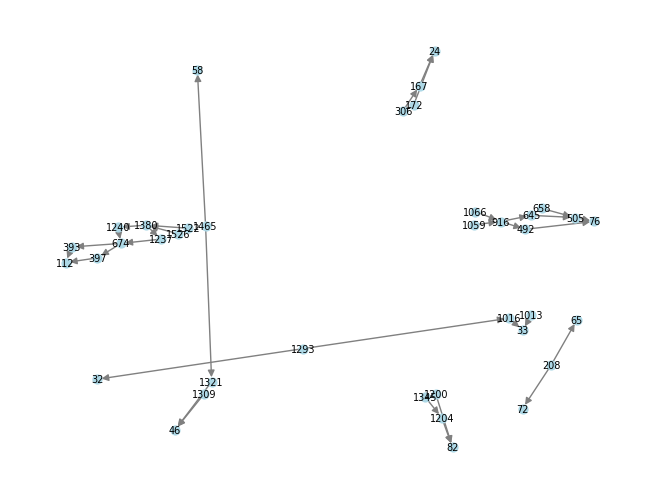

In [46]:
nx.draw(
    graph,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    node_size=40,
    font_size=7,
)
plt.show()

In [8]:
cellin = pc.CellLineage(graph)
cellin.plot()

Frames are incorrectly infered because of fusion events.

Manually by adding the nodes and edges:

In [36]:
nodes = set(
    [item for key, value_list in graph_data.items() for item in [key] + value_list]
)
len(nodes)

38

#### Get temporality from label stack tif

In [1]:
import pickle

# import napari
import networkx as nx
import matplotlib.pyplot as plt
import tifffile as tiff

import pycellin as pc

In [20]:
stack_file = "/mnt/data/Code/EpiCure_small_example/epics/013_crop_labels.tif"
epi_file = "/mnt/data/Code/EpiCure_small_example/epics/013_crop_epidata.pkl"

In [21]:
stack_array = tiff.imread(stack_file)
print(stack_array.shape)

(11, 160, 257)


For now just getting the nodes, no features like position, ROI or area.

In [22]:
all_labels = [set(stack_array[i].flatten()) for i in range(stack_array.shape[0])]
for f, list_labels in enumerate(all_labels):
    print(f, list_labels)
    print(len(list_labels))

0 {0.0, 1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0}
134
1 {0.0, 1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 3

In [12]:
set_labels = set.union(*all_labels)
len(set_labels)

161

Nodes are added from the stack tiff, while edges are added from the pickled EC file.

In [5]:
graph = nx.DiGraph()
current_noi = 0
for frame, labels in enumerate(all_labels):
    labels = [int(label) for label in labels if label != 0]
    nois = list(range(current_noi, current_noi + len(labels)))
    assert len(labels) == len(nois)
    current_noi += len(labels)
    nodes = [
        (noi, {"frame": frame, "label": label, "cell_ID": noi})
        for label, noi in zip(labels, nois)
    ]
    graph.add_nodes_from(nodes)
print(graph)

DiGraph with 1461 nodes and 0 edges


To add the edges:
- add an edge between each identical consecutive labels
- add an edge for each mother-daugther relationship in the pickle file

In [6]:
nb_frames = stack_array.shape[0]
for frame in range(nb_frames - 1):
    current_nodes = [
        node for node in graph.nodes if graph.nodes[node]["frame"] == frame
    ]
    next_nodes = [
        node for node in graph.nodes if graph.nodes[node]["frame"] == frame + 1
    ]
    for node in current_nodes:
        label = graph.nodes[node]["label"]
        if label in all_labels[frame + 1]:
            next_node = [n for n in next_nodes if graph.nodes[n]["label"] == label]
            assert len(next_node) <= 1
            if next_node:
                graph.add_edge(node, next_node[0])

In [7]:
cellin = pc.CellLineage(graph)
cellin.plot(node_hover_features=["cell_ID", "label", "frame"])

In [8]:
with open(epi_file, "rb") as f:
    epidata = pickle.load(f)
graph_data = epidata["Graph"]
print(graph_data)

{167: [24], 172: [24], 393: [112], 397: [112], 492: [76], 505: [76], 645: [505], 658: [505], 1013: [33], 1016: [33], 1059: [916], 1066: [916], 1204: [82], 1200: [82], 1237: [674], 1240: [674], 1309: [46], 1321: [46], 1522: [1380], 1526: [1380], 208: [65, 72], 306: [167, 172], 674: [393, 397], 916: [492, 645], 1293: [32, 1016], 1345: [1200, 1204], 1380: [1237, 1240], 1465: [1321, 58]}


In [9]:
for daughter_cell, mother_cells in graph_data.items():
    print(daughter_cell, mother_cells)

    # What we have here are labels, not cell IDs.
    # So we need to find the corresponding cell IDs.
    candidate_daughter_cell = [
        (node, frame)
        for node, frame in graph.nodes(data="frame")
        if graph.nodes[node]["label"] == daughter_cell
    ]
    # assert len(candidate_daughter_cell) > 0, print(candidate_daughter_cell)
    if len(candidate_daughter_cell) > 0:
        # The daughter cell involved in the division is the one with the lowest frame,
        # i.e. the first time that the label appears in the image.
        candidate_daughter_cell.sort(key=lambda x: x[1])
        daughter_cell_nid = candidate_daughter_cell[0][0]
        print("daughter_cell:", daughter_cell_nid)

        for mother_cell in mother_cells:
            # Same as above but with the mother cell.
            candidate_mother_cell = [
                (node, frame)
                for node, frame in graph.nodes(data="frame")
                if graph.nodes[node]["label"] == mother_cell
            ]
            # assert len(candidate_mother_cell) > 0, print(candidate_mother_cell)
            if len(candidate_mother_cell) > 0:
                candidate_mother_cell.sort(key=lambda x: x[1], reverse=True)
                mother_cell_nid = candidate_mother_cell[0][0]
                print("mother_cell:", mother_cell_nid)

                # Then we can add the edge to the graph.
                graph.add_edge(mother_cell_nid, daughter_cell_nid)

            else:
                print(f"Mother cell {mother_cell} not found in label image.")
    else:
        print(f"Daughter cell {daughter_cell} not found in label image.")

167 [24]
daughter_cell: 262
mother_cell: 20
172 [24]
daughter_cell: 263
mother_cell: 20
393 [112]
Daughter cell 393 not found in label image.
397 [112]
Daughter cell 397 not found in label image.
492 [76]
daughter_cell: 529
mother_cell: 333
505 [76]
daughter_cell: 530
mother_cell: 333
645 [505]
Daughter cell 645 not found in label image.
658 [505]
Daughter cell 658 not found in label image.
1013 [33]
Daughter cell 1013 not found in label image.
1016 [33]
daughter_cell: 1061
mother_cell: 1355
1059 [916]
daughter_cell: 1057
mother_cell: 928
1066 [916]
daughter_cell: 1058
mother_cell: 928
1204 [82]
Daughter cell 1204 not found in label image.
1200 [82]
Daughter cell 1200 not found in label image.
1237 [674]
Daughter cell 1237 not found in label image.
1240 [674]
Daughter cell 1240 not found in label image.
1309 [46]
Daughter cell 1309 not found in label image.
1321 [46]
daughter_cell: 1327
mother_cell: 1368
1522 [1380]
Daughter cell 1522 not found in label image.
1526 [1380]
Daughter cell

In [10]:
cellin = pc.CellLineage(graph)
cellin.plot(node_hover_features=["cell_ID", "label", "frame"])

### Regionprops on a stack tiff

In [1]:
import numpy as np
import pandas as pd
import tifffile as tiff
from skimage import measure, io

In [2]:
stack_file = "/mnt/data/Code/EpiCure_small_example/epics/013_crop_labels.tif"
stack_array = tiff.imread(stack_file).astype(np.uint16)
print(stack_array.shape)

(11, 160, 257)


In [3]:
array = io.imread(stack_file)
print(array.shape)

(11, 160, 257)


In [4]:
properties = ["label", "centroid"]
all_props = []
nb_row = 0
for frame in range(stack_array.shape[0]):
    props = measure.regionprops_table(
        stack_array[frame], properties=properties)
    props["frame"] = [frame] * len(props["label"])
    all_props.append(props)
    nb_row += len(props["label"])
# Reorganize the data as a numpy array which columns being label, pos_t, pos_x, pos_y
props_array = np.zeros((nb_row, 4))
props_array[:, 0] = np.concatenate([props["label"] for props in all_props])
props_array[:, 1] = np.concatenate([props["frame"] for props in all_props])
props_array[:, 2] = np.concatenate(
    [props["centroid-1"] for props in all_props])
props_array[:, 3] = np.concatenate(
    [props["centroid-0"] for props in all_props])
props_array

array([[1.00000000e+00, 0.00000000e+00, 3.26612903e+00, 7.58870968e+00],
       [2.00000000e+00, 0.00000000e+00, 1.57294118e+01, 7.73333333e+00],
       [4.00000000e+00, 0.00000000e+00, 3.43203125e+01, 6.79687500e+00],
       ...,
       [1.06600000e+03, 1.00000000e+01, 1.85505051e+01, 1.04959596e+02],
       [1.29300000e+03, 1.00000000e+01, 1.95482759e+02, 3.00324544e+01],
       [1.45600000e+03, 1.00000000e+01, 2.13698765e+02, 5.37851852e+01]])

In [5]:
label_array = props_array[:,0:2]
np.unique(label_array[:, 1]).astype(int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [6]:
props = measure.regionprops_table(stack_array[0], properties=properties)
props

{'label': array([  1,   2,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140]),
 'centroid-0': array([  7.58870968,   7.73333333,   6.796875  ,   1.92307692,
          5.25405405,   0.69047619,   7.73537604,   5.80743243,
         14.38876404,   2.75      ,   5.75272727,  12.71037182,
          8.67883212,   2.6393